In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import polars as pl
from jax import random
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import LabelEncoder

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
market_df = pl.read_csv(
    "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/multilevel_elasticities_single_sku_data.csv"
)

market_df.head()

item_id,price,quantities,time_step,store_id,region_store_id,region_id,median_income,log_price,log_quantities
i64,f64,f64,i64,i64,str,i64,f64,f64,f64
0,1.335446,6.170862,16,0,"""r-0_s-0""",0,5.873343,0.289265,1.819839
0,1.702792,3.715124,15,0,"""r-0_s-0""",0,5.873343,0.532269,1.312412
0,1.699778,3.290962,14,0,"""r-0_s-0""",0,5.873343,0.530498,1.19118
0,1.335844,5.702928,13,0,"""r-0_s-0""",0,5.873343,0.289563,1.74098
0,1.517213,4.264949,12,0,"""r-0_s-0""",0,5.873343,0.416875,1.45043


\begin{align*}

\log(q) & \sim  \text{Normal}(\mu, \sigma ^2) \\
\mu & =  \alpha + \beta \log(p) \\
\alpha & = \alpha_{\text{intercept}, j} + \alpha_{\text{slope}, j} m \\
\beta & = \beta_{\text{intercept}, j} + \beta_{\text{slope}, j} m \\

\begin{bmatrix}
\alpha_{\text{intercept}, j} \\
\beta_{\text{intercept}, j}
\end{bmatrix}
& \sim
\text{MultivariateNormal}(0, \Sigma_{\text{intercept}}) \\

\begin{bmatrix}
\alpha_{\text{slope}, j} \\
\beta_{\text{slope}, j}
\end{bmatrix}
& \sim
\text{MultivariateNormal}(0, \Sigma_{\text{slope}})\\

\Sigma_{\text{intercept}} & = \text{diag}(\sigma_{\alpha_{\text{intercept}}}^2, \sigma_{\beta_{\text{intercept}}}^2) \Omega_{\text{intercept}} \text{diag}(\sigma_{\alpha_{\text{intercept}}}^2, \sigma_{\beta_{\text{intercept}}}^2) \\

\Sigma_{\text{slope}} & = \text{diag}(\sigma_{\alpha_{\text{slope}}}^2, \sigma_{\beta_{\text{slope}}}^2) \Omega_{\text{slope}} \text{diag}(\sigma_{\alpha_{\text{slope}}}^2, \sigma_{\beta_{\text{slope}}}^2) \\

\Omega_{\text{intercept}} & \sim \text{LKJ}(1) \\

\Omega_{\text{slope}} & \sim \text{LKJ}(1) \\

\end{align*}

In [3]:
obs_idx = np.array(market_df.shape[0])

regions_encoder = LabelEncoder()
regions_encoder.fit(market_df["region_id"].to_numpy())
regions_idx = regions_encoder.transform(market_df["region_id"].to_numpy())
regions = regions_encoder.classes_

log_price = market_df["log_price"].to_jax()
log_quantities = market_df["log_quantities"].to_jax()

effect = ["intercept", "median_income"]

In [4]:
region_median_income_mapping_df = market_df.select(
    ["region_id", "median_income"]
).unique()

region_median_income_mapping_df = region_median_income_mapping_df.with_columns(
    region_idx=regions_encoder.transform(
        region_median_income_mapping_df["region_id"].to_numpy()
    )
).sort("region_idx")

median_income = region_median_income_mapping_df["median_income"].to_jax()

In [5]:
def model(log_price, regions_idx, median_income, log_quantities=None):
    dim = 2
    effects = 2
    n_obs = log_price.size
    n_regions = np.unique(regions_idx).size

    concentration = 2 * jnp.ones(1)

    with numpyro.plate("effect", effects, dim=-1):
        sigma_effect = numpyro.sample(
            "sigma_effect", dist.HalfNormal(scale=0.2 * jnp.ones(dim))
        )

        chol_corr = numpyro.sample(
            "chol_corr",
            dist.LKJCholesky(dimension=dim, concentration=concentration),
        )

        with numpyro.plate("regions", n_regions, dim=-2):
            z = numpyro.sample("z", dist.Normal(loc=0, scale=1))

    chol_cov = z @ (sigma_effect[None, ...] * chol_corr)

    alpha_region_effect = chol_cov[:, :, 0]
    beta_region_effect = chol_cov[:, :, 1]

    alpha_region_intercept = alpha_region_effect[0, :]
    alpha_region_median_income = alpha_region_effect[1, :]

    beta_region_intercept = beta_region_effect[0, :]
    beta_region_median_income = beta_region_effect[1, :]

    alpha_region = numpyro.deterministic(
        "alpha_region",
        alpha_region_intercept + alpha_region_median_income * median_income,
    )
    beta_region = numpyro.deterministic(
        "beta_region",
        beta_region_intercept + beta_region_median_income * median_income,
    )

    mu = alpha_region[regions_idx] + beta_region[regions_idx] * log_price

    nu = numpyro.sample("nu", dist.Gamma(concentration=20.0, rate=3))

    sigma = numpyro.sample("sigma", dist.Exponential(rate=1.0 / 0.5))

    with numpyro.plate("data", n_obs):
        numpyro.sample(
            "log_quantities",
            dist.StudentT(df=nu, loc=mu, scale=sigma),
            obs=log_quantities,
        )

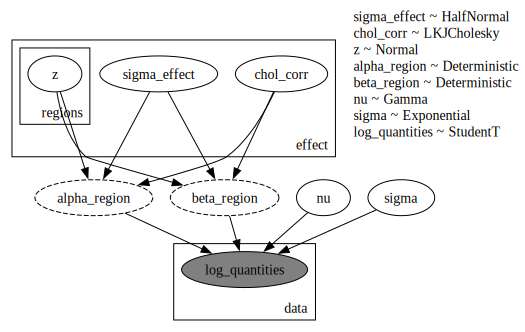

In [6]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "log_price": log_price,
        "regions_idx": regions_idx,
        "median_income": median_income,
        "log_quantities": log_quantities,
    },
    render_distributions=True,
    render_params=True,
)

In [7]:
sampler = NUTS(model)
mcmc = MCMC(
    sampler=sampler,
    num_warmup=1_000,
    num_samples=4_000,
    num_chains=4,
)

rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, log_price, regions_idx, median_income, log_quantities)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [8]:
idata = az.from_numpyro(
    mcmc,
    coords={"effect": effect, "regions": regions},
    dims={
        "sigma_effect": ["effect"],
        "z": ["regions", "effect"],
        "alpha_region": ["regions"],
        "beta_region": ["regions"],
    },
)

In [9]:
idata.sample_stats.diverging.sum().item()

0

In [10]:
az.summary(idata, var_names=["~z", "~chol_corr"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_region[0],2.753,0.051,2.659,2.851,0.000,0.000,16942.0,10959.0,1.0
alpha_region[1],2.993,0.056,2.890,3.099,0.000,0.000,17752.0,12471.0,1.0
alpha_region[2],2.439,0.035,2.375,2.505,0.000,0.000,18500.0,12247.0,1.0
alpha_region[3],3.607,0.140,3.343,3.870,0.001,0.001,16064.0,12019.0,1.0
alpha_region[4],2.989,0.052,2.892,3.087,0.000,0.000,17956.0,12205.0,1.0
alpha_region[5],2.826,0.057,2.716,2.930,0.000,0.000,17654.0,11651.0,1.0
alpha_region[6],3.082,0.049,2.991,3.174,0.000,0.000,17941.0,11681.0,1.0
alpha_region[7],2.343,0.029,2.289,2.399,0.000,0.000,18484.0,11681.0,1.0
alpha_region[8],2.541,0.039,2.467,2.612,0.000,0.000,17717.0,12496.0,1.0
beta_region[0],-3.559,0.123,-3.792,-3.333,0.001,0.001,17430.0,9895.0,1.0


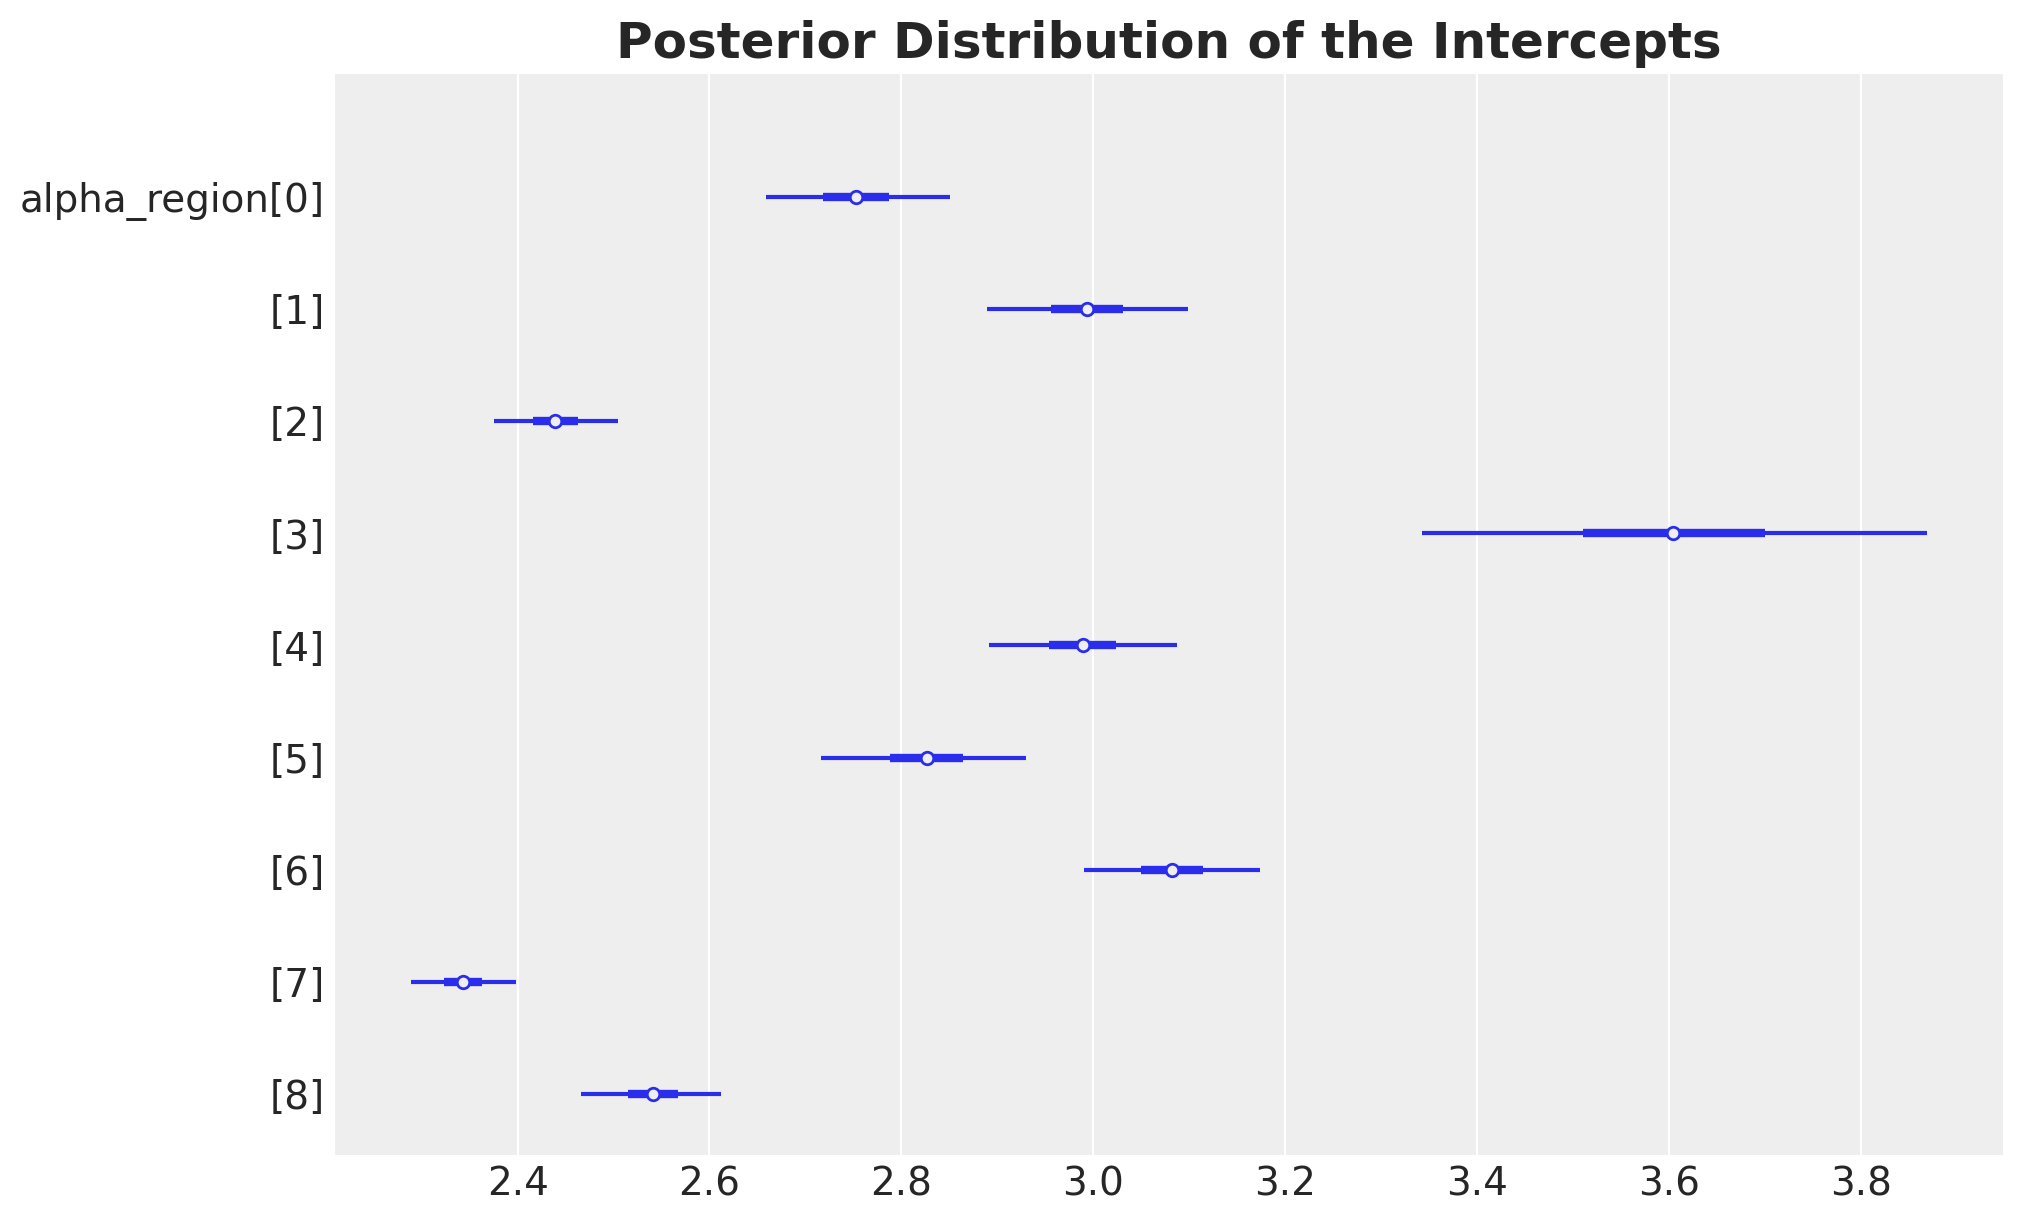

In [11]:
ax, *_ = az.plot_forest(
    data=idata,
    var_names=["alpha_region"],
    combined=True,
    figsize=(10, 6),
)
ax.set_title(
    label="Posterior Distribution of the Intercepts",
    fontsize=18,
    fontweight="bold",
);

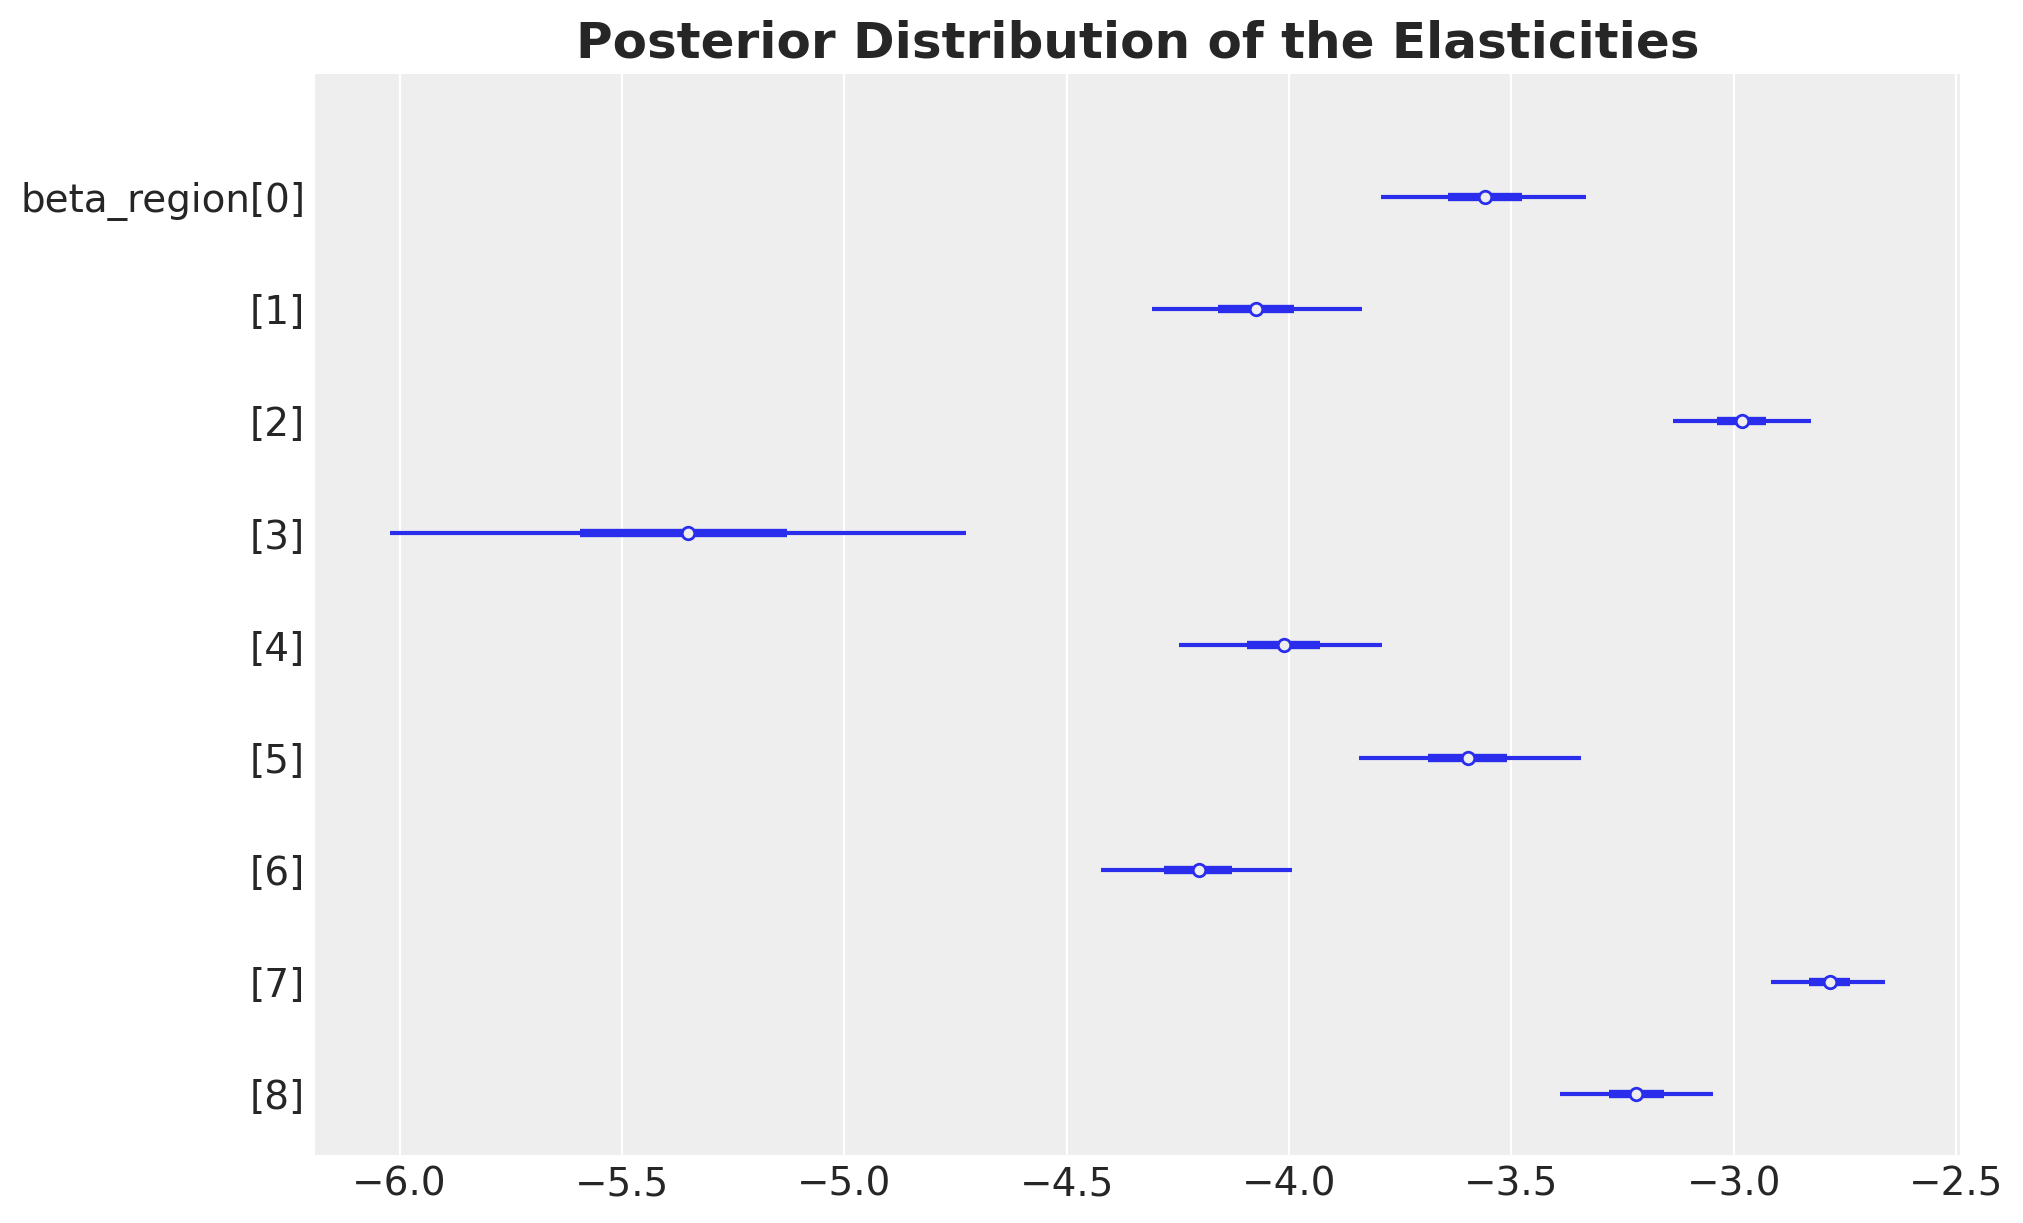

In [12]:
ax, *_ = az.plot_forest(
    data=idata,
    var_names=["beta_region"],
    combined=True,
    figsize=(10, 6),
)
ax.set_title(
    label="Posterior Distribution of the Elasticities",
    fontsize=18,
    fontweight="bold",
);